%load_ext autotime

# NN from scratch
## July 2024
## Tom Kelsey

- CS5938
- Planar flower data
- Only pandas and numpy for learning
- Some of the code adapted from https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%201/


In [15]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [16]:
# Import the Dataset

df = pd.read_csv ('flower2D.csv')
print(df.shape)
print(df.info())
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

(400, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  400 non-null    int64  
 1   X1          400 non-null    float64
 2   X2          400 non-null    float64
 3   Y           400 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 12.6 KB
None


,X1,X2,Y
0,0.005257,-0.303586,0
1,0.996098,3.461645,0
2,0.384404,2.392678,0
3,0.951043,3.282709,0
4,0.091932,1.066689,0


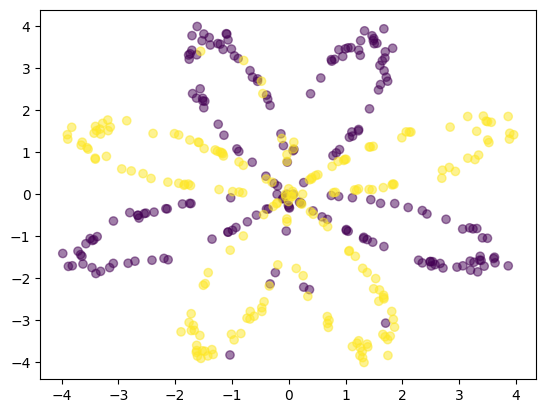

In [17]:
### Visualize the data
plt.scatter(df.X1, df.X2, c=df.Y, alpha=0.5)
plt.show()

### Shuffle the data
df = df.sample(frac=1)

### Preprocess into test and train sets

dataset, testDataset = np.split(df, [int(.7 * len(df))])
X = dataset.drop ('Y' , axis=1)
y = dataset['Y']
XX = testDataset.drop('Y', axis=1)
yy = testDataset['Y']

# Solution using libraries

- Define an architecture
- Load and use a package that does all the optimisation for us
- The task for this assignment is to write code that replaces the calls to library/package routines

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import *

clf = MLPClassifier(random_state=1 ,hidden_layer_sizes = (10,10,), max_iter=300).fit(X, y)
clf.predict_proba(XX)
clf.predict(XX)
clf.score(XX, yy)

0.8833333333333333

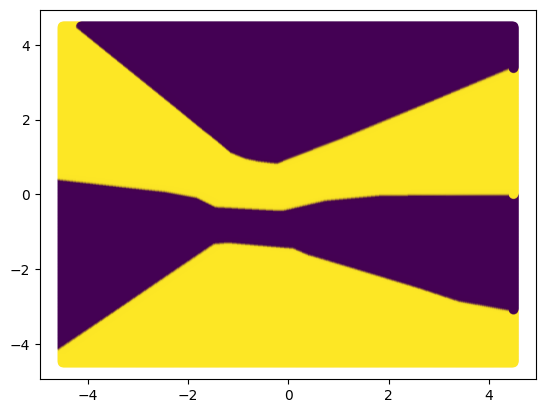

In [20]:
## Plot decision boundaries for the model
from itertools import product
points = np.array(list(product(range(-450,450),range(-450,450))))
mypoints = points*0.01

gridpreds = np.where(clf.predict(mypoints) > 0.5, 1, 0)

plt.scatter(mypoints[:,0],mypoints[:,1], c=gridpreds, alpha=0.5)
plt.show()

# Preliminary models from scratch

- The data has two classes that are not easily separable
- So logistic regression (or similar) is probably not a good choice
- So we'll use simple neural net models
- The steps will be:


1. Define the neural net architecture
2. Initialize the model’s parameters (all 0.5 to be sure that updates have an effect)  
3. Loop:
    - Implement forward propagation.
    - Compute loss.
    - Implement backward propagation to get the gradients.
    - Update parameters.
4. Assess performance


In [21]:
## Arrange the data into correct matrix form for learning
## Instances are columns instaed of rows

X, y = df[["X1","X2"]], np.array(df["Y"])

m = 300
m_test = X.shape[0] - m
X_train, X_test = X[:m].T, X[m:].T
y_train, y_test = y[:m].reshape(1,m), y[m:].reshape(1,m_test)

In [22]:
## Define output scale, loss and learning rate 

# Output is a probability between 0 and 1
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

# Cross entropy loss
def compute_loss(Y, Y_hat):

    m = Y.shape[1]
    L = -(1./m) * ( np.sum( np.multiply(np.log(Y_hat),Y) ) + np.sum( np.multiply(np.log(1-Y_hat),(1-Y)) ) )

    return L

learning_rate = 0.1

# Step 1. No hidden layers

- Equivalent to logistic regression

In [23]:
X = X_train
Y = y_train

n_x = X.shape[0]
m = X.shape[1]

half = [0.5]
W = np.array([half]*n_x)
b = np.array([half])


for i in range(2000):
    Z = np.matmul(W.T, X) + b
    A = sigmoid(Z)

    cost = compute_loss(Y, A)

    dW = (1/m) * np.matmul(X, (A-Y).T)
    db = (1/m) * np.sum(np.array(A-Y), axis=1, keepdims=True)

    W = W - learning_rate * dW
    b = b - learning_rate * db

    
## Check that weights and biases have changed from 0.5
print(W)
print(b)

           0
X1 -0.025775
X2 -0.256980
[[0.14093871]]


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

Z = np.matmul(W.T, X_test) + b
A = sigmoid(Z)

predictions = np.where(A > 0.5, 1, 0)
labels = np.where(y_test > 0.5, 1, 0)

cm = confusion_matrix(predictions[0], labels[0])
print(cm)
tn, fp, fn, tp = cm.ravel()
model_score = (tn+tp)/(tn+ fp+ fn+ tp)
print(model_score)

[[24 10]
 [36 30]]
0.54


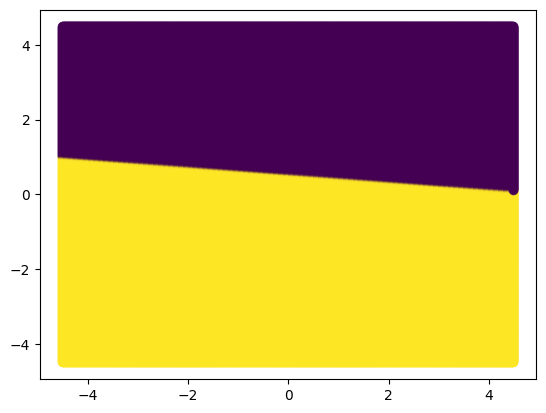

In [25]:
## Plot decision boundaries for the model
dbZ = np.matmul(W.T, mypoints.T) + b
bdA = sigmoid(dbZ)

bdpreds = np.where(bdA > 0.5, 1, 0)

plt.scatter(mypoints[:,0],mypoints[:,1], c=bdpreds, alpha=0.5)
plt.show()

# Step 2. One hidden layer

- Using logistic function as the internal activation function

In [26]:
# One hidden layer with 100 nodes

X = X_train
Y = y_train

n_x = X.shape[0]
n_h = 100
learning_rate = 0.01

b1 = np.zeros((n_h, 1))+0.5
b2 = np.zeros((1, 1))+0.5

W1 = np.ones((n_h,n_x))*0.5
W2 = np.array([[0.5]*n_h])

for i in range(2000):

    Z1 = np.matmul(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.matmul(W2, A1) + b2
    A2 = sigmoid(Z2)

    cost = compute_loss(Y, A2)

    dZ2 = A2-Y
    dW2 = (1./m) * np.matmul(dZ2, A1.T)
    db2 = (1./m) * np.sum(np.array(dZ2), axis=1, keepdims=True)

    dA1 = np.matmul(W2.T, dZ2)
    dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1))
    dW1 = (1./m) * np.matmul(dZ1, X.T)
    db1 = (1./m) * np.sum(np.array(dZ1), axis=1, keepdims=True)

    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1


In [27]:
Z1 = np.matmul(W1, X_test) + b1
A1 = sigmoid(Z1)
Z2 = np.matmul(W2, A1) + b2
A2 = sigmoid(Z2)

predictions = np.where(A2 > 0.5, 1, 0)
labels = np.where(y_test > 0.5, 1, 0)

cm = confusion_matrix(predictions[0], labels[0])
print(cm)
tn, fp, fn, tp = cm.ravel()
model_score = (tn+tp)/(tn+ fp+ fn+ tp)
print(model_score)


[[39 10]
 [21 30]]
0.69


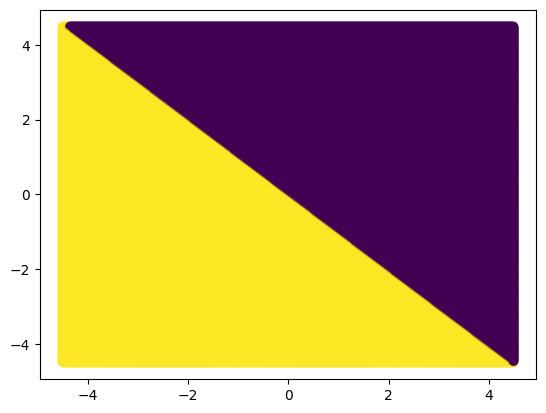

In [28]:
## Plot decision boundaries for the model
dbZ1 = np.matmul(W1, mypoints.T) + b1
dbA1 = sigmoid(dbZ1)
dbZ2 = np.matmul(W2, dbA1) + b2
dbA2 = sigmoid(dbZ2)


bdpreds = np.where(dbA2 > 0.5, 1, 0)

plt.scatter(mypoints[:,0],mypoints[:,1], c=bdpreds, alpha=0.5)
plt.show()

# The task

- Simple forward and backpropagation has been implemented
- Models can be compared for accuracy (score), decision boundaries and confusion matrices

1. Seek to improve the one-layer model by changing the internal activation function. This will involve changing A1 to something else, and also changing the derivative involving one or both of dAI and dZ1
2. Add another layer with your choice of activation function (other than the logistic function) and your choice of internal nodes
3. Add a third layer
4. Add a fourth layer
4. Report on your choices and assessment of the resulting models
5. Based on your answers to tasks 1-4, write code that - for this dataset - allows a user to build and run a neural net with a high degree of flexibility in terms of architecture and hyperperameter choices.




